# Spiegel Online news topics and COVID-19

## A topic modeling approach

November 25, 2020 | Markus Konrad <markus.konrad@wzb.eu> | [WZB / Berlin Social Science Center](https://wzb.eu/)

This is the main part of a small project to showcase topic modeling with the [tmtoolkit Python package](https://tmtoolkit.readthedocs.io/) via [LDA](https://lda.readthedocs.io/), where I use a corpus of *[Spiegel Online (SPON)](https://www.spiegel.de/)* news articles to create a topic model for before and during the COVID-19 pandemic. In the notebook at hand, I load and investigate the generated topic model and identify COVID-19 related topics. I then show how the share of COVID-19 related topics – as a measure of media coverage on COVID-19 – developed during the pandemic and, as a quick example, how this relates to national and global COVID-19 infection rates.

For an introduction to topic modeling via LDA see [Introduction to Probabilistic Topic Models (Blei 2012)](https://oar.princeton.edu/jspui/bitstream/88435/pr1bv3w/1/OA_IntroductionProbabilisticTopicModels.pdf) or [Topic modeling made just simple enough (Underwoord 2012)](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/).

Currently, a time span from Oct. 2019 to end of Aug. 2020 is covered but I plan to give an update for a time span until end of Nov. 2020. The time span begins well before Jan. 2020 in order to make sure that also enough topics are generated that have nothing to do with the pandemic.

The results of other Python scripts in this repository enter this notebook, namely:

1. text data preparation in [`prepare.py`](prepare.py)
2. topic model evaluation in [`tm_evaluation.py`](tm_evaluation.py)
3. generation of final candidate topic models in [`tm_final.py`](tm_final.py)

Please have a look at the [GitHub repository](https://github.com/WZBSocialScienceCenter/tm_corona) which contains all necessary files.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_rows = 200

## Data loading

We load a candidate model that was generated in `tm_final.py` (for this example, we only investigate the first of the candidate models that are stored in `'data/tm_final_results.pickle'`).

In [2]:
from tmtoolkit.utils import unpickle_file

ldamodel = unpickle_file('data/tm_final_k180_eta0.7.pickle')

doc_topic = ldamodel.doc_topic_
topic_word = ldamodel.topic_word_

doc_topic.shape, topic_word.shape

((32921, 180), (180, 3278))

We see that we have a model with 180 topics. The shape of the document-topic and topic-word distributions tell us also the number of documents (32,921) and the vocabulary size (3,278) for which the model was generated.

We load the document labels, vocabulary and document-term matrix (DTM) which were genereted in `prepare.py`.

In [3]:
doc_labels, vocab, dtm = unpickle_file('data/dtm.pickle')
doc_labels = np.array(doc_labels)
vocab = np.array(vocab)
len(doc_labels), len(vocab), dtm.shape

(32921, 3278, (32921, 3278))

The dimensions of the DTM fit to the number of documents and vocabulary size.

First ten document labels:

In [4]:
doc_labels[:10]

array(['007-drehorte-in-europa-klimavertraeglicher-james-bond-a-1295233',
       '070-shake-in-berlin-vertrauensuebung-mit-einer-emo-rapperin-a-7c4a0eb3-7c1b-474c-aaee-f2de6e165362',
       '1-fc-heidenheim-in-der-relegation-demoliert-in-die-groessten-spiele-der-vereinsgeschichte-a-383ce249-6865-4bfa-a8ea-2a89894ad7b2',
       '1-fc-heidenheim-unterliegt-werder-bremen-in-der-relegation-da-helfen-auch-keine-klatschpfannen-a-ea0861b0-dd7c-403a-99ab-38b6c25c7aed',
       '1-fc-kaiserslautern-beantragt-in-der-3-liga-insolvenz-pfaelzer-sauplan-a-69b7ee5a-5cc8-4f8c-9f67-c5f455a3ec9f',
       '1-fc-kaiserslautern-fussball-drittligist-stellt-antrag-auf-plan-insolvenz-a-fb530286-9b7b-4cd7-ae1f-9a876cc3f700',
       '1-fc-koeln-beendet-kooperation-mit-china-totaler-ueberwachungsstaat-a-1301960',
       '1-fc-koeln-holt-horst-heldt-und-markus-gisdol-neue-gesichter-alte-zweifel-a-1297292',
       '1-fc-koeln-kontert-kuendigung-eines-mitglieds-wegen-moschee-auf-dem-trikot-a-0fc58882-dffd-4f84-a157-

First ten terms in vocabulary:

In [5]:
vocab[:10]

array(['10', '11', '20', 'ab', 'abbauen', 'abbrechen', 'abend', 'abends',
       'abgeben', 'abgeordnete'], dtype='<U27')

DTM is a large sparse matrix with the expected dimensions:

In [6]:
dtm

<32921x3278 sparse matrix of type '<class 'numpy.int32'>'
	with 4247828 stored elements in Compressed Sparse Row format>

## Investigating the topic model

Let's investigate how quick the probabilities in the topic-word matrix fall with the term ranks. For each topic (i.e. each row in the topic-word matrix), we sort the term probabilities in descending order and plot these sorted topic-specific term probabilities.

Note: I will add a function for such plots to the next major version of [tmtoolkit](https://tmtoolkit.readthedocs.io/).

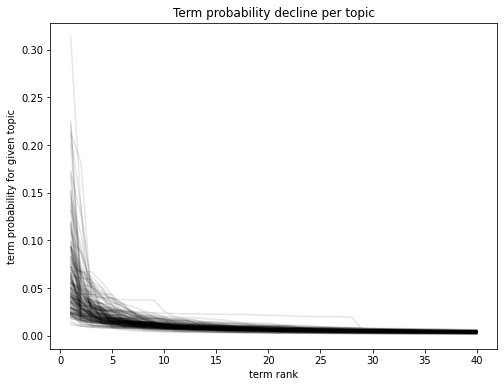

In [7]:
import matplotlib.pyplot as plt

# rowwise sorting 
# (NumPy still doesn't support descending order, hence the "-" hack)
topic_word_desc = -np.sort(-topic_word, axis=1)   

fig, ax = plt.subplots(figsize=(8, 6))
n_terms = 40  # show ranks 1 to 40
term_ranks = np.arange(1, n_terms+1)
for t in topic_word_desc:
    ax.plot(term_ranks, t[:n_terms], color = 'black', alpha=0.1)

ax.set_title('Term probability decline per topic')
ax.set_xlabel('term rank')
ax.set_ylabel('term probability for given topic')
fig;

This shows us that if we rank the terms in each topic, only the first five to ten terms really represent the topic. All other terms are really close to each other regarding their probabilities, so their ranking becomes more or less meaningless.

This finding helps us to later focus on the top five or so terms in each topic, when we try to interpret the top terms per topic.

When we look closely, we see that the ordered probability distribution for three of the 180 topics seems special compared to the other topics. Let's highlight these topics. We want to identify the three topics that stand out in the plot above, i.e that have the highest term probability at the term ranks 1, 7 and 25:

In [8]:
# we use indices for the ranks here, hence we start at 0
highlight_topics = np.argsort(-topic_word_desc[:, [0, 7, 24]], axis=0)[0, :]
highlight_topics

array([131, 158,  93])

Let's plot these results. This time, we use a log-scale for the y-axis to be able to better descern the individual topics:

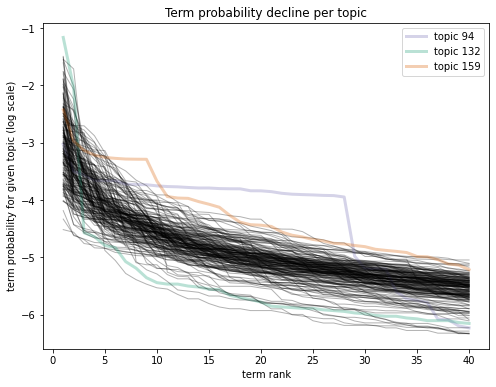

In [9]:
palette = plt.get_cmap('Dark2')

fig, ax = plt.subplots(figsize=(8, 6))
highlight_topics_handles = []
for i, t in enumerate(topic_word_desc):
    highlight_index = np.where(i == highlight_topics)[0]
    if len(highlight_index) > 0:
        color = palette(highlight_index[0])
        label = 'topic ' + str(i+1)
        lw = 3
    else:
        color = 'black'
        label = 'other topics'
        lw = 1
    
    hndl, = ax.plot(term_ranks, np.log(t[:n_terms]), color=color, label=label, lw=lw, alpha=0.3)
    
    if len(highlight_index) > 0:
        highlight_topics_handles.append(hndl)

ax.set_title('Term probability decline per topic')
ax.set_xlabel('term rank')
ax.set_ylabel('term probability for given topic (log scale)')
ax.legend(handles=highlight_topics_handles, loc='best')
fig;

The highlighted topics are #94, #132 and #159. We will later have a closer look at them.

We will now further investigate the topics and try to identify topics of interest to us, i.e. topics related to the COVID-19 pandemic. Before we continue, we apply a transformation to the topic-word matrix: We use [topic-word relevance](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Topic-word-relevance) ([Sievert & Shirley 2014](https://www.aclweb.org/anthology/W14-3110/)) which *"helps to identify the most relevant words within a topic by also accounting for the marginal probability of each word across the corpus"*, i.e. this transformation puts a penalty on terms that are more common (have a higher marginal probability) and therefore pushes more "specific" terms to higher ranks in each topic.

In [10]:
from tmtoolkit.topicmod.model_stats import topic_word_relevance
from tmtoolkit.bow.bow_stats import doc_lengths

doclengths = doc_lengths(dtm)

topic_word_rel = topic_word_relevance(topic_word, doc_topic, doclengths, lambda_=0.6)
topic_word_rel

array([[-6.56622682, -6.47633154, -6.48707646, ..., -6.72499435,
        -6.64484627, -5.20960509],
       [-7.43442808, -7.3445328 , -7.35527771, ..., -6.70589241,
        -5.11515226, -7.42773306],
       [-6.78071434, -6.69081905, -6.70156397, ..., -5.58955515,
        -5.97203059, -6.77401932],
       ...,
       [-7.14246662, -7.05257133, -7.06331625, ..., -7.30123414,
        -5.31684861, -7.1357716 ],
       [-3.15177778, -4.50491935, -3.50897469, ..., -7.03836263,
        -5.02925396, -6.09519551],
       [-7.59616309, -7.5062678 , -7.51701272, ..., -3.97399302,
        -6.00977477, -7.58946807]])

We can now try to identify our topics of interest. We can do this computationally, e.g. by using [filter_topics()](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Filtering-topics) and by specifying a list of search terms. By this, we identify all topics that contain at least one matching term in their `top_n=10` terms (remember we found out that 5 to 10 of its top terms sufficiently determine the topic). Note that we use the topic-word relevance matrix `topic_word_rel` here instead of the topic-word matrix, because we want the top terms list to be determined by the mentioned relevance metric instead of the topic-specific term probabilities.

In [11]:
from tmtoolkit.topicmod.model_stats import filter_topics

covid19_topics_automatic = filter_topics(['corona*', 'covid*', 'pandemie', 'sars*', 'infektion', 'rki'],
                                         vocab, topic_word_rel, match_type='glob', top_n=10)
covid19_topics_automatic + 1       # covid19_topics are topic *indices*; we add 1 to get topic numbers

array([ 13,  28,  76,  90,  93, 108, 120, 126, 131, 155, 168, 180])

Alternatively (and you should do this anyway) is to look at the top terms of each topic and try to interpret each topic. This is feasible for 180 topics. By this, you can also identify COVID-19 related topics that don't involve the keywords above but maybe synonyms that you didn't think of. Furthermore, you make sure that the topics in your topic model make sense. As long as there's only a small fraction of "nonsensical" topics (which happens most of the time with LDA), you know your model is okay and you can identify and later exclude such topics.

There are several ways to display and export topic modeling results, specifically the document-topic and topic-word distributions. See [this section in the tmtoolkit documentation](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Displaying-and-exporting-topic-modeling-results) for the available options. We will export the results to a Excel file, which allows to easily investigate topics and mark them accordingly:

In [12]:
from tmtoolkit.topicmod.model_io import save_ldamodel_summary_to_excel

# this takes some time since the topic model is quite large

# save_ldamodel_summary_to_excel('output/tm_final_k180_eta0.7.xlsx',
#                                topic_word, doc_topic, doc_labels, vocab,
#                                dtm = dtm);
# save_ldamodel_summary_to_excel('output/tm_final_k180_eta0.7_tw_relevance.xlsx',
#                                topic_word_rel, doc_topic, doc_labels, vocab,
#                                dtm=dtm);

I manually identified the following COVID-19 related topics (yellow background) as well as nonsensical (gray background) in `output/tm_final_k180_eta0.7_tw_relevance.xlsx` (see the `top_topic_word_labels` sheet):

In [13]:
# substract 1 to get topic *indices* (these start at topic 0)

nonsensical_topics = np.array([7, 8, 46, 47, 61, 63, 64, 74, 78, 80,
                               93, 94, 97, 111, 113, 122, 124, 129,
                               139, 159, 170]) - 1
covid19_topics = np.array([13, 24, 28, 35, 50, 76, 90, 108, 126,
                           131, 135, 152, 155, 168, 180]) - 1

In [14]:
len(nonsensical_topics), len(covid19_topics)

(21, 15)

Most topics can be interpreted very well (see the Excel file). With a little more than 10% nonsensical topics (mostly consisting of very common words), however, we could probably remove more common words in the preprocessing step and generate a model that consists of a bit fewer topics. But I think for our purposes here the model is sufficient. It's also interesting to see how the model captures different perspectives of the pandemic in separate topics, e.g *topic_24* relating to wearing masks, *topic_50* relating to relaxing the Corona countermeasures or *topic_131* relating to vaccines against the virus. 

We also see that we found a few different topics as compared to the "keyword search" approach. We found the following topics additionally:

In [15]:
set(covid19_topics+1) - set(covid19_topics_automatic+1)

{24, 35, 50, 135, 152}

Let's have a look at the top 10 terms for these additionally found topics:

In [16]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

ldamodel_top_topic_words(
    topic_word_rel,
    vocab,
    top_n=10).iloc[sorted(set(covid19_topics) - set(covid19_topics_automatic)),:]

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
topic_24,maske (0.7224),maskenpflicht (0.02156),tragen (-0.2841),trage (-0.5087),schutzmasken (-0.6864),pflicht (-1.121),nase (-1.261),mund (-1.328),einkaufen (-1.596),verstoß (-1.604)
topic_35,spahn (0.3342),test (0.007197),jens (-0.08562),gesundheitsminister (-0.4132),testen (-0.8518),labor (-0.9737),robert (-1.62),deutschland (-1.705),kostenlos (-1.951),sagen (-1.975)
topic_50,lockerungen (-0.8067),öffnung (-1.114),öffnen (-1.175),schrittweise (-1.263),mai (-1.375),lockerung (-1.425),normalität (-1.545),lockern (-1.547),land (-1.697),sollen (-1.72)
topic_135,hand (-0.5646),abstand (-0.7781),waschen (-0.8674),husten (-0.9921),sollen (-0.9941),empfehlen (-1.103),meter (-1.122),halten (-1.294),luft (-1.602),einhalten (-1.695)
topic_152,arzt (0.08259),patient (0.04521),klinik (-0.1198),krankenhaus (-0.4784),krankenhäuser (-0.7729),behandlung (-0.778),intensivstation (-0.8414),medizinisch (-0.9082),behandeln (-0.9243),mediziner (-1.016)


We can see that by manually investigating the top words per topic, we identified Corona-related topics which didn't find with our set of keywords, because it's hard to create a comprehensive set of keywords.

The following topics we didn't manually identify as COVID-19 related topics:

In [17]:
set(covid19_topics_automatic+1) - set(covid19_topics+1)

{93, 120}

Let's investigate the top 10 terms for these two topics in order to make sure that we correctly identified these topics as *not* Corona-related:

In [18]:
ldamodel_top_topic_words(
    topic_word_rel,
    vocab,
    top_n=10).iloc[sorted(set(covid19_topics_automatic) - set(covid19_topics)),:]

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
topic_93,uhr (-0.5045),coronavirus (-2.113),sagen (-2.135),mensch (-2.176),mehr (-2.316),angabe (-2.326),infektion (-2.35),teilen (-2.354),zahl (-2.368),coronakrise (-2.396)
topic_120,prozent (-0.4142),quartal (-0.9742),wirtschaft (-1.244),minus (-1.258),rückgang (-1.299),erwarten (-1.527),rechnen (-1.565),einbruch (-1.58),coronakrise (-1.594),stark (-1.595)


*topic_93* was not selected as Corona-related since it seems nonsensical (it's actually in the list of nonsensical topics). *topic_120* was not selected since the topic is mainly about economy and "coronakrise" as only Corona-related term is only on the 9th rank. However, we should later include these topics in a sensitivity analysis.

We can now [exclude nonsensical topics](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Excluding-topics) from our model:

In [19]:
from tmtoolkit.topicmod.model_stats import exclude_topics

doc_topic, topic_word, new_topic_mapping =  exclude_topics(
    nonsensical_topics, doc_topic, topic_word, return_new_topic_mapping=True
)
doc_topic.shape, topic_word.shape

((32921, 159), (159, 3278))

This leaves us with 159 topics. Note that the topic indices of the previously identified COVID-19 related topics now don't match to the new document-topic and topic-word distributions anymore. We can update the indices by using `new_topic_mapping` as returned from `exclude_topics()`:

In [20]:
old_topic_ind, new_topic_ind = map(lambda x: np.array(list(x)),
                                   (new_topic_mapping.keys(), new_topic_mapping.values()))
covid19_topics = new_topic_ind[np.searchsorted(old_topic_ind, covid19_topics)]
covid19_topics

array([ 10,  21,  25,  32,  45,  67,  79,  94, 108, 112, 116, 132, 135,
       147, 158])

We can also [generate labels for the topics](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Generating-labels-for-topics) from their top-ranking words. This helps when refering to specific topics.

In [21]:
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

topic_labels = generate_topic_labels_from_top_words(
    topic_word,
    doc_topic,
    doclengths,
    vocab,
    lambda_=0.6
)


These are the topic labels for our COVID-19 related topics:

In [22]:
topic_labels[covid19_topics]

array(['11_pandemie_coronakrise', '22_maske_maskenpflicht',
       '26_neuinfektionen_zahl', '33_spahn_test', '46_lockerungen_öffnen',
       '68_wuhan_coronavirus', '80_virus_sarscov2',
       '95_schließen_maßnahme', '109_coronakrise_kurzarbeit',
       '113_impfstoff_medikament', '117_hand_abstand', '133_arzt_patient',
       '136_zahl_todesfälle', '148_quarantäne_positiv',
       '159_coronakrise_corona'], dtype='<U33')

A quick look at the marginal topic distribution shows us the most prominent topics in our corpus:

In [23]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(doc_topic, doclengths)
list(sorted(zip(topic_labels, marg_topic), key=lambda x: x[1], reverse=True))[:20]

[('26_neuinfektionen_zahl', 0.015712434406330807),
 ('75_minute_tor', 0.012762950363237005),
 ('108_trump_donald', 0.01272651858438072),
 ('105_prozent_quartal', 0.012365290954533646),
 ('80_virus_sarscov2', 0.012150155180471557),
 ('46_lockerungen_öffnen', 0.011952432146179335),
 ('95_schließen_maßnahme', 0.011331682833765531),
 ('158_bayer_dortmund', 0.01112611539262225),
 ('93_gates_foundation', 0.010949357258572412),
 ('119_leben_mensch', 0.010779585583945827),
 ('136_zahl_todesfälle', 0.010306918241285478),
 ('107_prozent_zahl', 0.010126169620470383),
 ('68_wuhan_coronavirus', 0.010071376604688579),
 ('159_coronakrise_corona', 0.010035174941218018),
 ('32_gericht_verurteilen', 0.009998688185347377),
 ('34_begriff_medium', 0.009733718116205612),
 ('11_pandemie_coronakrise', 0.00972157511571275),
 ('101_song_musik', 0.009688675866130446),
 ('87_modell_motor', 0.009622671837856773),
 ('66_politisch_demokratie', 0.009520435686119617)]

For the whole corpus (which includes about as much news articles from before the pandemic as from during the pandemic), we can calculate the overall share of Corona-related topics:

In [24]:
sum(marg_topic[covid19_topics])

0.13442846454584428

## Daily COVID-19 cases and COVID-19 related topics in the news

We now focus on the chronological development of the share of COVID-19 related topics as well as how this relates to the number of daily COVID-19 cases. We will calculate a share of COVID-19 related topics which represents our measure of COVID-19 media coverage on SPON.

First, we load the corpus metadata that was generated in `prepare.py`:

In [25]:
corpusmeta = unpickle_file('data/meta.pickle')

We retrieve the publication date for each news article (in the same order as `doc_labels`):

In [26]:
doc_dates = np.array([corpusmeta[d]['pub_date'] for d in doc_labels], dtype='datetime64')
doc_dates

array(['2019-11-13', '2020-01-28', '2020-06-29', ..., '2019-12-28',
       '2019-12-30', '2020-08-24'], dtype='datetime64[D]')

Now we calculate the marginal distribution of COVID-19 related topics per news article:

In [27]:
marg_covid19 = np.sum(doc_topic[:, covid19_topics], axis=1)
marg_covid19

array([0.00674433, 0.01073171, 0.00950735, ..., 0.01285347, 0.04862579,
       0.48698885])

Let's put this all together with the document labels and document lengths in a dataframe:

In [28]:
docs_covid19 = pd.DataFrame({
    'label': doc_labels,
    'date': doc_dates,
    'length': doclengths,
    'marginal_covid19': marg_covid19
})
docs_covid19

,label,date,length,marginal_covid19
0,007-drehorte-in-europa-klimavertraeglicher-jam...,2019-11-13,310,0.006744
1,070-shake-in-berlin-vertrauensuebung-mit-einer...,2020-01-28,265,0.010732
2,1-fc-heidenheim-in-der-relegation-demoliert-in...,2020-06-29,226,0.009507
3,1-fc-heidenheim-unterliegt-werder-bremen-in-de...,2020-07-07,244,0.004907
4,1-fc-kaiserslautern-beantragt-in-der-3-liga-in...,2020-06-17,269,0.094440
...,...,...,...,...
32916,zwoelf-kinder-als-chefsache-a-d4533bfa-668c-49...,2020-04-11,421,0.129314
32917,zyklon-amphan-trifft-auf-indien-und-bangladesc...,2020-05-20,203,0.004484
32918,zypern-diebe-stehlen-koffer-mit-urne-darin-a-1...,2019-12-28,57,0.012853
32919,zypern-mutmassliche-urnendiebe-gefasst-familie...,2019-12-30,70,0.048626


Sorting by marginal distribution gives us the documents with highest share of Corona-related topics:

In [29]:
docs_covid19.sort_values('marginal_covid19', ascending=False)

,label,date,length,marginal_covid19
8017,coronavirus-der-mund-nasen-schutz-ersetzt-nich...,2020-04-24,338,0.959401
8505,coronavirus-infizierte-genesene-tote-alle-live...,2020-03-18,394,0.946813
6949,corona-mundschutz-tragen-oder-nicht-tragen-a-e...,2020-04-02,391,0.934810
7130,corona-robert-koch-institut-meldet-hoechste-za...,2020-08-19,165,0.930165
5184,china-wie-gefaehrlich-ist-das-neuartige-corona...,2020-01-20,432,0.916635
...,...,...,...,...
22974,niederlande-dsgvo-oma-muss-facebook-foto-ihres...,2020-05-22,881,0.001030
11708,eine-kuh-erklaert-die-welt-a-b4a34c61-2b89-447...,2020-02-25,855,0.000996
2697,berlin-alexanderplatz-auf-der-berlinale-kaltes...,2020-02-26,856,0.000975
2929,berlinale-2020-perspektive-deutsches-kino-a-78...,2020-02-22,867,0.000969


We want to calculate an estimate of the *daily* share of Corona-related topics. Since for each day we have several news articles of different lengths, we can compute this estimate as the weighted average of the marginal COVID-19 topic probability of each news article per day. The weights are the share of an article's length compared to the total length of all articles on that day.

Let's first compute the weights:

In [30]:
docs_covid19['weight'] = docs_covid19.groupby('date')\
    .length.transform(lambda g: g / g.sum())    # here "g" contains all articles' lengths on a given day
docs_covid19

,label,date,length,marginal_covid19,weight
0,007-drehorte-in-europa-klimavertraeglicher-jam...,2019-11-13,310,0.006744,0.013959
1,070-shake-in-berlin-vertrauensuebung-mit-einer...,2020-01-28,265,0.010732,0.013212
2,1-fc-heidenheim-in-der-relegation-demoliert-in...,2020-06-29,226,0.009507,0.011430
3,1-fc-heidenheim-unterliegt-werder-bremen-in-de...,2020-07-07,244,0.004907,0.011631
4,1-fc-kaiserslautern-beantragt-in-der-3-liga-in...,2020-06-17,269,0.094440,0.011453
...,...,...,...,...,...
32916,zwoelf-kinder-als-chefsache-a-d4533bfa-668c-49...,2020-04-11,421,0.129314,0.021682
32917,zyklon-amphan-trifft-auf-indien-und-bangladesc...,2020-05-20,203,0.004484,0.008875
32918,zypern-diebe-stehlen-koffer-mit-urne-darin-a-1...,2019-12-28,57,0.012853,0.004819
32919,zypern-mutmassliche-urnendiebe-gefasst-familie...,2019-12-30,70,0.048626,0.004296


We check that all weights sum up to 1 per day:

In [31]:
np.allclose(docs_covid19.groupby('date').weight.sum(), 1.0)

True

We now compute the daily share of Corona-related topics:

In [32]:
ts_covid19topics = docs_covid19.groupby('date').apply(lambda g: (g.weight * g.marginal_covid19).sum())
ts_covid19topics

date
2019-10-01    0.031422
2019-10-02    0.039168
2019-10-03    0.034717
2019-10-04    0.031006
2019-10-05    0.026473
                ...   
2020-08-26    0.137607
2020-08-27    0.151143
2020-08-28    0.118545
2020-08-29    0.111597
2020-08-30    0.071660
Length: 335, dtype: float64

Check that we're within the limits of a valid probability:

In [33]:
np.all((0 <= ts_covid19topics) & (ts_covid19topics <= 1))

True

Finally, let's plot the share of COVID-19 topics over time:

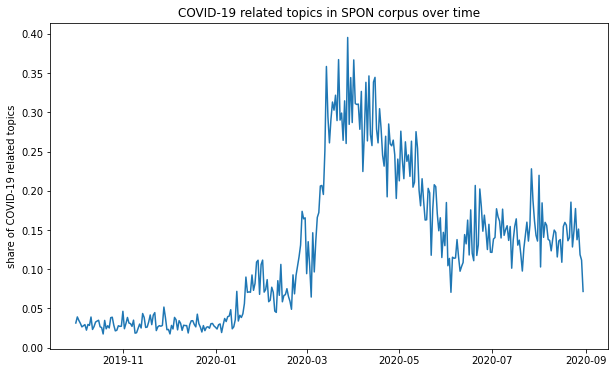

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ts_covid19topics.index, ts_covid19topics)
ax.set_ylabel('share of COVID-19 related topics')
ax.set_title('COVID-19 related topics in SPON corpus over time')
fig.savefig('plots/covidtopics_time.png')
fig;

We see clearly how media coverage on SPON got a first uptick in February when the first reports from the new lung disease in Wuhan arrived (this is how it's called in the first articles on SPON). By March and April media coverage skyrockets with a daily topic share of almost 40%. Note however, that we don't have information on how the respective articles were positioned on the website (i.e. frontpage news or rather positioned at the bottom of the page) and hence this doesn't need to reflect actually percepted media coverage by the public – it only reflects what was published anywhere on the page on that date. Furthermore, the LDA approach that we used for topic modeling views documents as *mixtures* of topics. This means all documents, including those that cover COVID-19 in some way, also cover other topics to some degree. For example, an article may cover the pandemic and its impact on the economy and hence contain a mixture of, say, 60% COVID-19 related topics, 30% economy related topics and 10% other topics. So you shouldn't think about the topic share displayed in the figure above as something like "x% of all articles covered COVID-19 on a given day". You should rather think of it like that: In the topic mixture of all articles on a given day taken together, x% were related to COVID-19.

It is hence no surprise that the peak of COVID-19 related topic share is "only" at around 40% although you may have had a different impression from the news at that time: First, our sample includes *all* articles, also those dozens of articles on soccer results or "lifestyle" at the bottom of the page. Second, only the fewest articles solely cover COVID-19. Almost all of them will be a mixture of several topics.

In order to see how this relates to the number of daily COVID-19 cases, we first load data that I fetched from the [COVID-19 DataHub](https://covid19datahub.io/) *(Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.)*. The dataset is not part of the repository. You can download it at https://covid19datahub.io/articles/data.html#vintage-data.

In [35]:
coviddatahub_full = pd.read_csv('data/covid19datahub-2020-11-19.csv')
coviddatahub_full['date'] = pd.to_datetime(coviddatahub_full.date)
coviddatahub_full.head()

,id,date,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,currency,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,latitude,longitude,key,key_apple_mobility,key_google_mobility
0,AFG,2020-01-01,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
1,AFG,2020-01-02,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
2,AFG,2020-01-03,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
3,AFG,2020-01-04,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF
4,AFG,2020-01-05,0,0,0,0,0,0,0,37172386,...,AFN,1,Afghanistan,NaN,NaN,33.0,65.0,NaN,NaN,AF


We create a subset for our observation period and the variables of interest:

In [36]:
coviddatahub = coviddatahub_full.loc[
    (coviddatahub_full.date >= '2020-01-01') & (coviddatahub_full.date <= docs_covid19.date.max()),
    ['id', 'date', 'confirmed', 'administrative_area_level_1']
]

The variable *confirmed* contains the *accumlated* number of confirmed COVID-19 cases per day. We need the daily cases so we apply `diff()` on that column per country:

In [37]:
coviddatahub['daily'] = coviddatahub.groupby('id').confirmed.diff().fillna(0).astype(np.int)
coviddatahub.head()

,id,date,confirmed,administrative_area_level_1,daily
0,AFG,2020-01-01,0,Afghanistan,0
1,AFG,2020-01-02,0,Afghanistan,0
2,AFG,2020-01-03,0,Afghanistan,0
3,AFG,2020-01-04,0,Afghanistan,0
4,AFG,2020-01-05,0,Afghanistan,0


First, let's investigate Germany and create a subset for that:

In [38]:
coviddata_de = coviddatahub.loc[coviddatahub.id == 'DEU', :]
coviddata_de.head()

,id,date,confirmed,administrative_area_level_1,daily
15228,DEU,2020-01-01,0,Germany,0
15229,DEU,2020-01-02,0,Germany,0
15230,DEU,2020-01-03,1,Germany,1
15231,DEU,2020-01-04,1,Germany,0
15232,DEU,2020-01-05,1,Germany,0


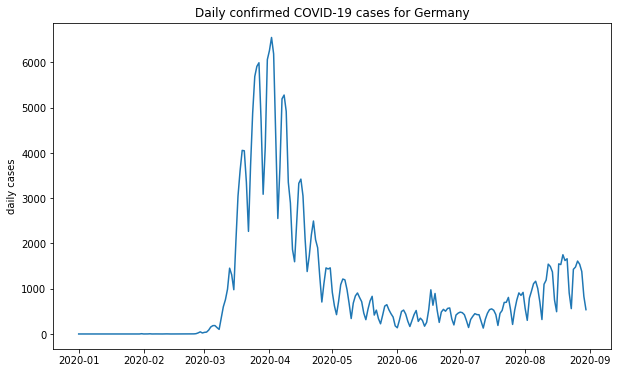

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(coviddata_de.date, coviddata_de.daily)
ax.set_ylabel('daily cases')
ax.set_title('Daily confirmed COVID-19 cases for Germany')
fig;

Let's repeat this for a dataset that represents worldwide daily COVID-19 cases:

In [40]:
coviddata_world = coviddatahub.groupby('date').daily.sum()

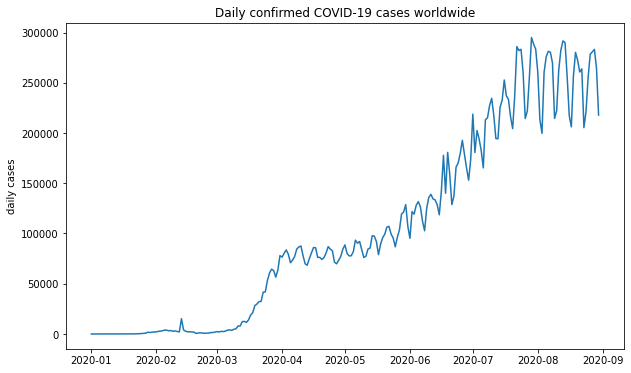

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(coviddata_world.index, coviddata_world)
ax.set_ylabel('daily cases')
ax.set_title('Daily confirmed COVID-19 cases worldwide')
fig;

### Relationship between infection rate in Germany and share of COVID-19 related topics on SPON

We will now investigate how the share of COVID-19 topics relates to the number of daily COVID-19 cases in Germany.

In [42]:
ts_covid19topics2020 = ts_covid19topics[ts_covid19topics.index >= '2020-01-01']

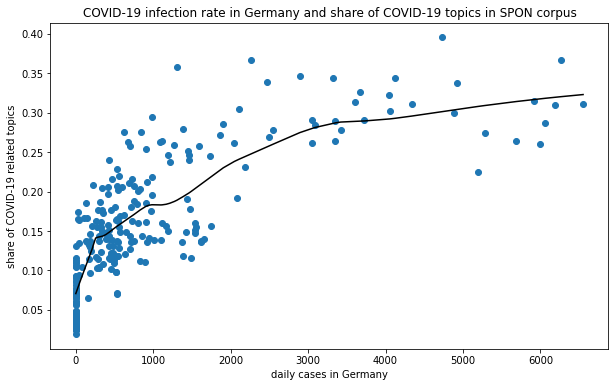

In [43]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

smoothed = sm.nonparametric.lowess(ts_covid19topics2020, coviddata_de.daily,
                                   frac=0.5)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(coviddata_de.daily, ts_covid19topics2020)
ax.plot(smoothed[:, 0], smoothed[:, 1], c='black')
ax.set_xlabel('daily cases in Germany')
ax.set_ylabel('share of COVID-19 related topics')
ax.set_title('COVID-19 infection rate in Germany and share of COVID-19 topics in SPON corpus')
fig.savefig('plots/covidrate_topics_germany.png')
fig;

We can see that for daily numbers in the range of up to ~1,000 cases, higher case numbers are associated with a sharp increase in media coverage on SPON in our time frame. After that, the curve flattens until it consolidates at a high level.

Note: No, the *LOWESS* (aka *LOESS*) smoother in Python's *statsmodels* package doesn't support confidence intervals, yet.

We could try to fit a function to this data to get more insights about the relationship between the number of cases in Germany and the share of COVID-19 related topics. We could fit a simple linear model with a single term, i.e. *covid19topics ~ dailycases*, but this wouldn't account for the damping effect that sets in at higher numbers of cases. Adding a quadratic term, i.e. specifying the model as *covid19topics ~ dailycases + dailycases²*, may be used to account for the damping effect while still providing a simple, interpretable model.

Let's specify such a model:

In [44]:
topics_cases = pd.DataFrame({
    'covid19topics': ts_covid19topics2020.values,
    'dailycases': coviddata_de.daily.values
})

lm_topics_cases = smf.ols('covid19topics ~ dailycases + np.square(dailycases)', data=topics_cases).fit()
lm_topics_cases.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          covid19topics   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     260.3
Date:                Wed, 25 Nov 2020   Prob (F-statistic):           7.71e-61
Time:                        10:58:55   Log-Likelihood:                 397.52
No. Observations:                 243   AIC:                            -789.0
Df Residuals:                     240   BIC:                            -778.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0919      0.005     20.336      0.000       0.083       0.101
dailycases                0.0001    6.5e-06     15.980      0.000    9.11e-05       0.000
np.square(dailycases) -1.169e-08   1.21e-09     -9.638      0.000   -1.41e-08    -9.3e-09
==============================================================================
Omnibus:                        4.503   Durbin-Watson:                   0.778
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.600
Skew:                           0.326   Prob(JB):                        0.100
Kurtosis:                       2.828   Cond. No.                     1.20e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can plot the model fit and interpret the results below.

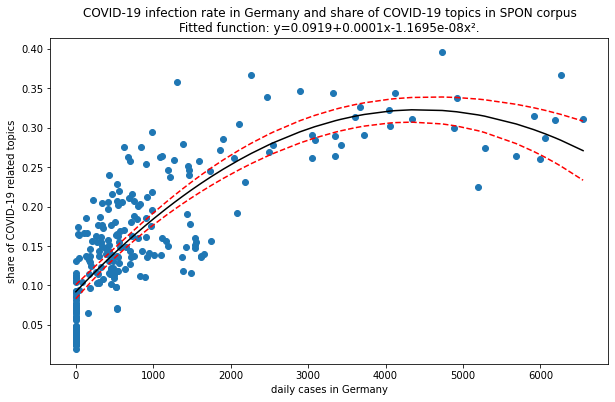

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

predinput = np.sort(np.unique(topics_cases.dailycases))
predresults = lm_topics_cases.get_prediction(pd.DataFrame({'dailycases': predinput}))\
    .summary_frame(alpha=0.05)

ax.scatter(topics_cases.dailycases, topics_cases.covid19topics)
ax.plot(predinput,
        lm_topics_cases.predict(pd.DataFrame({'dailycases': predinput})),
        c='black')
ax.plot(predinput, predresults.mean_ci_upper, 'r--')
ax.plot(predinput, predresults.mean_ci_lower, 'r--')
ax.set_xlabel('daily cases in Germany')
ax.set_ylabel('share of COVID-19 related topics')
ax.set_title('COVID-19 infection rate in Germany and share of COVID-19 topics in SPON corpus\n'
             'Fitted function: y={:.4f}{:+.4f}x{:+.4e}x².'
             .format(*(lm_topics_cases.params.values).tolist()))
fig.savefig('plots/covidrate_topics_germany_lm.png')
fig;

Starting with a share of Corona-related topics of around $0.09$ for no reported cases in Germany, the linear term can be interpretated as an increase of $0.1$ in Corona-related topic share **per 1000 cases**. The damping effect of the squared term with the negative coefficient sets in at higher numbers of daily cases. For example, at 1000 cases, the dampening effect is only around $-1.17 \cdot 10^{-8} \cdot 1000^2 = -0.0117$, but at 4000 cases it is already $-1.17 \cdot 10^{-8} \cdot 4000^2 = -0.19$.

### Relationship between worldwide infection rate and share of COVID-19 related topics on SPON

Let's have a look at the relationship between *worldwide* daily Corona cases and share of COVID-19 related topics. We can make a similar figure as for the cases in Germany:

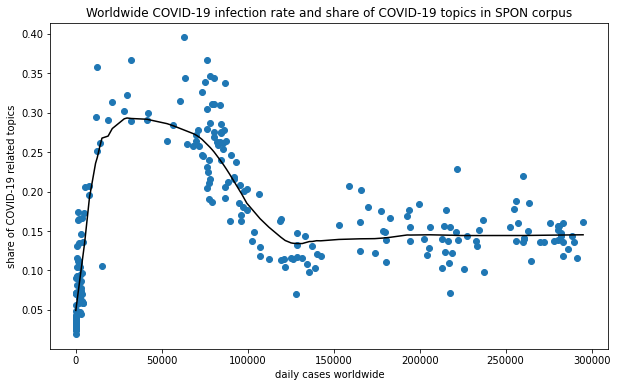

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

smoothed = sm.nonparametric.lowess(ts_covid19topics2020, coviddata_world,
                                   frac=0.3)

ax.scatter(coviddata_world, ts_covid19topics2020)
ax.plot(smoothed[:, 0], smoothed[:, 1], c='black')
ax.set_xlabel('daily cases worldwide')
ax.set_ylabel('share of COVID-19 related topics')
ax.set_title('Worldwide COVID-19 infection rate and share of COVID-19 topics in SPON corpus')
fig.savefig('plots/covidrate_topics_world.png')
fig;

We can see that there's not such a clear relationship between the worldwide infection rate and share of COVID-19 related topics on SPON as compared to the data from Germany. There's a sharp increase in the share of COVID-19 related topics on SPON until around 40,000 cases which coincides with the sharp increase of Corona cases in Germany in spring 2020. Despite of increasing daily infections in the world, the share of COVID-19 related topics decreases first and then stays constant at around $15\%$ for 130,000 daily cases and more.

### Conclusion

This notebook is supposed to showcase how topic models can be used to identify topics of interest in large-scale text data and how certain properties of these topics like their marginal probability can be used for further analyses.

In the case of SPON, we found that national daily infection numbers clearly drive the volume of media coverage on COVID-19 during our time frame (January 2020 to end of August 2020), which is probably not very suprising. Even though infection rates increased dramatically in the world in summer 2020 (e.g. in Brazil, India and USA), media coverage first decreased and then stayed at a moderate level. But also regarding the national situation, media coverage on SPON stagnated on a high level with increasing infection rates in Germany. It will be interesting to see if this pattern holds with the second "Corona wave", that hit Germany in late autumn 2020, or if there's a "weariness" about media coverage that may lead to decreasing coverage despite of rising infection rates.